Temat: "Predykcja czasu osiągnięcia odporności zbiorowej w przypadku COVID-19 w grupie Wyszehradzkiej"

Zespół: Blanka Piekarz, Marcin Stachura

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

df = pd.read_csv('./country_vaccinations.csv', delimiter=',')

columnsToDrop = ['iso_code', 'daily_vaccinations_raw', 'source_website', 'source_name',
                 'vaccines', 'people_fully_vaccinated_per_hundred',
                 'people_vaccinated_per_hundred', 'total_vaccinations_per_hundred']

data = df.drop(columnsToDrop, 1)
data = data[data['daily_vaccinations'].notna()]

#  ---- ADD POPULATION -----
df_population = pd.read_csv("population.csv", delimiter=',', sep=',', header=2, usecols=['Country Name', '2019'])
df_population.loc[df_population['Country Name'] == 'Slovak Republic', 'Country Name'] = 'Slovakia'

for i in range(0,len(df_population)):
    data.loc[data['country'] == df_population.loc[i, 'Country Name'], 'population'] = df_population.loc[i, '2019']

#  ---- VISEGRAD STATISTICS / FILL NaN -----
visegrad_countries = ['Poland', 'Czech Republic', 'Hungary', 'Slovakia']
visegrad_data = data[data['country'].isin(visegrad_countries)]
for i in range(0, len(visegrad_countries)):
    visegrad_data.loc[visegrad_data['country'] == visegrad_countries[i], 'country'] = i

visegrad_data = visegrad_data.reset_index(drop=True)

import datetime as dt
visegrad_data['date'] = pd.to_datetime(visegrad_data['date'])
# visegrad_data['date'] = visegrad_data['date'].map(dt.datetime.toordinal)

date_column = visegrad_data['date'].copy()
country_column = visegrad_data['country'].copy()

visegrad_data = visegrad_data.fillna(visegrad_data.mean())
visegrad_data

C:\Users\Cinek\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,daily_vaccinations_per_million,population
0,2,2020-12-29,2.461000e+03,919149.748,434856.429224,1367.0,142.0,9769949.0
1,2,2020-12-30,3.789000e+03,919149.748,434856.429224,1348.0,140.0,9769949.0
2,2,2020-12-31,5.110000e+03,919149.748,434856.429224,1339.0,139.0,9769949.0
3,2,2021-01-01,1.225371e+06,919149.748,434856.429224,1578.0,163.0,9769949.0
4,2,2021-01-02,1.225371e+06,919149.748,434856.429224,1722.0,178.0,9769949.0
...,...,...,...,...,...,...,...,...
280,3,2021-03-31,9.814890e+05,719418.000,262071.000000,17141.0,3140.0,5454073.0
281,3,2021-04-01,1.006283e+06,742643.000,263640.000000,18052.0,3306.0,5454073.0
282,3,2021-04-02,1.011040e+06,747298.000,263742.000000,16083.0,2946.0,5454073.0
283,3,2021-04-03,1.017903e+06,753997.000,263906.000000,14994.0,2746.0,5454073.0


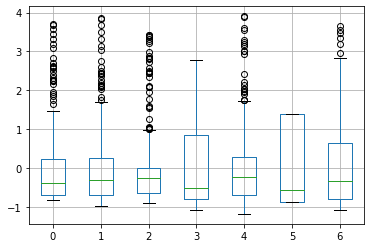

In [256]:
#  ---- STANDARDIZATION ----
visegrad_data['total_vaccinations_percentage'] = visegrad_data['total_vaccinations']/visegrad_data['population']
visegrad_data = visegrad_data.drop(['date'], 1)
visegrad_data = visegrad_data.drop(['country'], 1)


visegrad_values = visegrad_data.values
X_standard_scaler = visegrad_values - visegrad_values.mean(axis=0)
X_standard_scaler = X_standard_scaler / visegrad_values.std(axis=0)

# X_standard_scaler.hist(figsize=(30,30))
dr = pd.DataFrame(X_standard_scaler)
dr.boxplot()

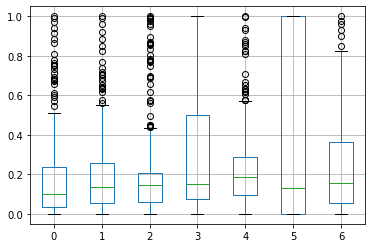

In [257]:
#  ---- STANDARDIZATION - USING SKLEARN ----
from sklearn import preprocessing

values = visegrad_data.values
min_max_scaler = preprocessing.MinMaxScaler()
data_input_scaled = min_max_scaler.fit_transform(values)
df_new = pd.DataFrame(data_input_scaled)

df_new.boxplot()

In [258]:
df_new.describe()

,0,1,2,3,4,5,6
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,0.183968,0.200370,0.209516,0.283111,0.232849,0.385991,0.226769
std,0.220145,0.207000,0.230580,0.259270,0.196708,0.445101,0.211297
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032554,0.054363,0.057926,0.074668,0.096695,0.000000,0.055672
50%,0.099481,0.136441,0.148280,0.148994,0.186353,0.132728,0.153972
75%,0.235216,0.255347,0.209516,0.499670,0.287842,1.000000,0.363269
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [259]:
from sklearn.model_selection import train_test_split

X = dr.values[:,2:]
y = dr.values[:,-1:] #or: y = dr.values[:,:2]  ?

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=False)

In [260]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.9982644507211733
0.0006716595065881931


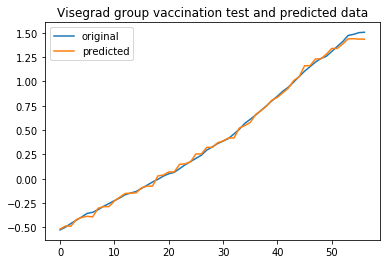

In [261]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Visegrad group vaccination test and predicted data")
plt.legend()
plt.show()

In [262]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
print(svr.score(X_test, y_test))
y_pred_svr = svr.predict(X_test)
x_ax = range(len(y_test))
mse = mean_squared_error(y_test, y_pred_svr)
print(mse)

0.9858256931346177
0.005485472565704683


C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


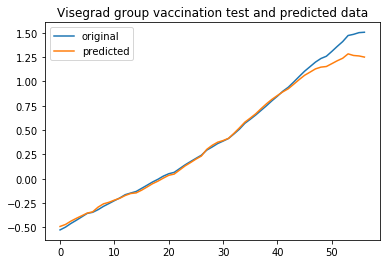

In [263]:

plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_svr, label="predicted")
plt.title("Visegrad group vaccination test and predicted data")
plt.legend()
plt.show()

In [264]:
import math
def accuracy(actual, predicted):
    """accuracy = (tp + tn) / ts

    , where:

        ts - Total Samples
        tp - True Positives
        tn - True Negatives
    """
    return (actual == predicted).sum() / float(len(actual))

def get_r2(x, y):
    zx = (x-np.mean(x))/np.std(x, ddof=1)
    zy = (y-np.mean(y))/np.std(y, ddof=1)
    r = np.sum(zx*zy)/(len(x)-1)
    return r**2

y_prediction = np.reshape(y_pred, (y_pred.shape[0], -1))
actual    = (np.array(y_test) == 2)
predicted = (np.array(y_prediction) < 0.5)
print(accuracy(actual, predicted))



print(get_r2(y_test, y_prediction))

y_prediction_svr = np.reshape(y_pred_svr, (y_pred_svr.shape[0], -1))
actual    = (np.array(y_test) == 2)
predicted_svr = (np.array(y_prediction_svr) < 0.5)
print(accuracy(actual, predicted_svr))



print(get_r2(y_test, y_prediction_svr))

0.42105263157894735
0.9983065841539123
0.42105263157894735
0.9934327406100409


In [265]:
"""
---x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x---
ZAJĘCIA 25.03
PRZYKŁAD OPARTY NA: load_iris()
---x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x---
"""

'\n---x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x---\nZAJĘCIA 25.03\nPRZYKŁAD OPARTY NA: load_iris()\n---x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x---\n'

In [266]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd

data = load_iris()

data = pd.DataFrame(data.data, columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [267]:
target = load_iris().target
data['target'] = target

data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [268]:
X = data.values[:,:-1]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True)

In [269]:
X_train.shape

(120, 4)

In [270]:
X_test.shape

(30, 4)

In [271]:
y_train.shape

(120,)

In [272]:
y_test.shape

(30,)

In [273]:
from sklearn import svm

clf = svm.SVC(C=0.05)
clf.fit(X_train, y_train)

SVC(C=0.05)

In [274]:
clf.score(X_test, y_test)

0.7

In [275]:
clf.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 0])